# Sample design: simple random sample

In [32]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib as matplotlib
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
from shapely import wkt
from shapely.geometry import Point, Polygon, MultiPoint
import geopandas as gpd
import xarray as xr

In [12]:
np.random.seed(0)
repo_path = Path('/Users/etriesch/dev/ocean-carbon-sampling/')
data_clean_path = repo_path / 'data/clean/'
data_raw_path = repo_path / 'data/raw/'
geo_crs = 'epsg:4326'
proj_crs = '+proj=cea'

In [13]:
# load coastlines (saved locally)
boundary_fp = data_raw_path / 'stanford-vg541kt0643-shapefile.zip'
boundary = gpd.read_file(data_path / boundary_fp).to_crs(geo_crs)

In [14]:
# Monterrey desal mask
ca_cent = [-121.788649, 36.802834]
ca_lats = [33.48, 39.48]
ca_lons = [-125.48, -119.48]
# Texas desal mask
tx_cent = [-95.311296, 28.927239]
tx_lats = [25.57, 31.57]
tx_lons = [-98.21, -92.21]
# NH desal mask
nh_cent = [-70.799678, 42.563588]
nh_lats = [39.38, 45.38]
nh_lons = [-73.50, -67.50]

# Create ocean boundaries

In [15]:
# make disks
ca_disc = gpd.GeoSeries(Point(ca_cent), crs=proj_crs).buffer(1.5).set_crs(geo_crs, allow_override=True)
ca_disc = gpd.GeoDataFrame(geometry=ca_disc)
tx_disc = gpd.GeoSeries(Point(tx_cent), crs=proj_crs).buffer(1.5).set_crs(geo_crs, allow_override=True)
tx_disc = gpd.GeoDataFrame(geometry=tx_disc)
nh_disc = gpd.GeoSeries(Point(nh_cent), crs=proj_crs).buffer(1.5).set_crs(geo_crs, allow_override=True)
nh_disc = gpd.GeoDataFrame(geometry=nh_disc)

# cut discs at coastal boundary
ca = ca_disc.overlay(boundary, how='difference')
tx = tx_disc.overlay(boundary, how='difference')
nh = nh_disc.overlay(boundary, how='difference')

In [16]:
# make rectangles (not used)
def get_bounding_box(lats, lons):
    geometry = []
    for i in lons:
        for j in lats:
            geometry += [Point(i,j)]
    geo = Polygon(geometry).envelope
    geo = gpd.GeoDataFrame(geometry=gpd.GeoSeries(geo, crs=geo_crs))
    return geo
ca_box = get_bounding_box(ca_lats, ca_lons)
tx_box = get_bounding_box(tx_lats, tx_lons)
nh_box = get_bounding_box(nh_lats, nh_lons)

## Read in temp and color data

In [17]:
# read data
t_raw = pd.read_csv(data_clean_path / 'sst.csv')
c_raw = pd.read_csv(data_clean_path / 'chlor_a.csv')
# c_ann_raw = pd.read_csv(data_clean_path / 'chlor_a_annual.csv')

In [18]:
# merge on x/y values
m = pd.merge(left=c_raw, right=t_raw, how='inner', on=['x', 'y'], suffixes=('_c', '_t'))

In [19]:
# make geodataframe
geo = [Point(lon, lat) for lat, lon in zip(m.lat_c, m.lon_c)]
geo_m = gpd.GeoDataFrame(m, geometry=geo, crs=geo_crs)

## Subset to sample zones

In [89]:
# make sample zones
# first convert points to convex hulls, then resnip them to the coastlines
pac_sample_zone = MultiPoint((geo_m.overlay(ca, how='intersection').geometry.values)).convex_hull
pac_sample_zone = gpd.GeoSeries(pac_sample_zone, crs=geo_crs)
pac_sample_zone = gpd.GeoDataFrame(geometry=pac_sample_zone).overlay(ca, how='intersection')

atl_sample_zone = MultiPoint((geo_m.overlay(nh, how='intersection').geometry.values)).convex_hull
atl_sample_zone = gpd.GeoSeries(atl_sample_zone, crs=geo_crs)
atl_sample_zone = gpd.GeoDataFrame(geometry=atl_sample_zone).overlay(nh, how='intersection')

gul_sample_zone = MultiPoint((geo_m.overlay(tx, how='intersection').geometry.values)).convex_hull
gul_sample_zone = gpd.GeoSeries(gul_sample_zone, crs=geo_crs)
gul_sample_zone = gpd.GeoDataFrame(geometry=gul_sample_zone).overlay(tx, how='intersection')

# Simple random sampling
Using rejection sampling. Here we scale up the number of target samples relative to the bounding box containing the sampling zone, then sample the entire bounding box, and reject any samples not in the sampling zone. It can be shown that the sample points are uniformly randomly distributed within our target sampling zone

In [85]:
def rejection_sample(n, region):
    # get fraction of sampling area
    sample_area = region.to_crs(proj_crs).area
    total_area = (gpd.GeoDataFrame(
            geometry=gpd.GeoSeries(
                Polygon([Point([region.bounds.minx, region.bounds.miny]), Point([region.bounds.minx, region.bounds.maxy]), 
                         Point([region.bounds.maxx, region.bounds.miny]), Point([region.bounds.maxx, region.bounds.maxy])]),
                crs=geo_crs).envelope).to_crs(proj_crs).area)
    pct_sample_area = sample_area / total_area
    
    # scale up target sample size to account for this
    n_scale = int(np.ceil(n / pct_sample_area))
    
    # generate lat lons
    lon = np.random.uniform(region.bounds.minx, region.bounds.maxx, n_scale)
    lat = np.random.uniform(region.bounds.miny, region.bounds.maxy, n_scale)
    geo = [Point(lat, lon) for lat, lon in zip(lon, lat)]
    geo_sub = [pt for pt in geo if region.contains(pt).values]
    print(f'Targeted {n} samples, {len(geo_sub)} returned ({len(geo_sub)-n})')
    
    return gpd.GeoSeries(geo_sub, crs=region.crs)

In [86]:
SAMPLES = 200

In [90]:
ca_samples = rejection_sample(SAMPLES, pac_sample_zone)
tx_samples = rejection_sample(SAMPLES, gul_sample_zone)
nh_samples = rejection_sample(SAMPLES, atl_sample_zone)

Targeted 200 samples, 209 returned (9)
Targeted 200 samples, 188 returned (-12)
Targeted 200 samples, 196 returned (-4)


In [91]:
# make tuples of sample zones, discs, and desalination plant locations
PAC = [ca_samples, ca, ca_cent] # pacific
ATL = [nh_samples, nh, nh_cent] # atlantic
GUL = [tx_samples, tx, tx_cent] # gulf

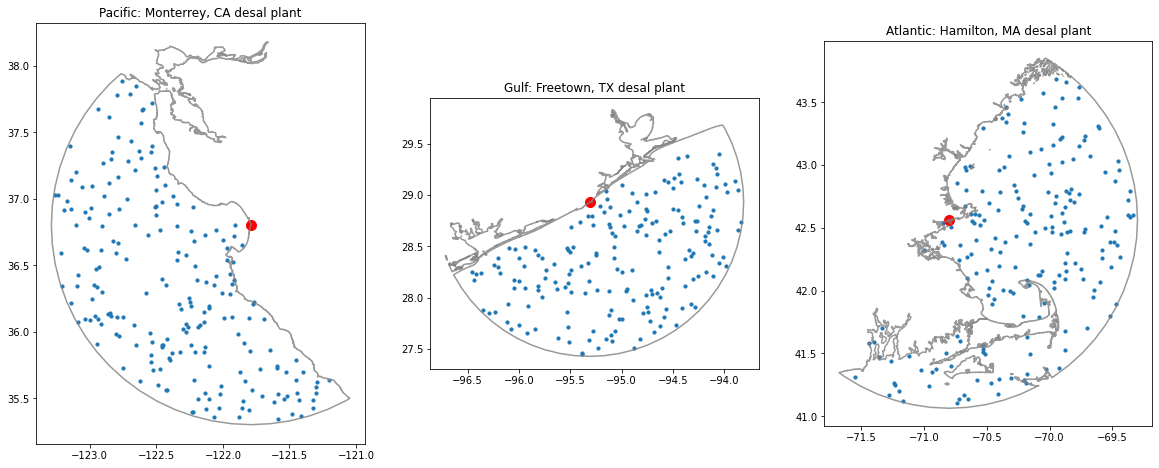

In [94]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,20))

# pacific
PAC[1].boundary.plot(ax=ax1, alpha=0.8, color='gray')
PAC[0].plot(ax=ax1, markersize=10)
gpd.GeoSeries(Point(PAC[2])).plot(ax=ax1, color='r', markersize=100)
ax1.set_title('Pacific: Monterrey, CA desal plant')
# gulf
GUL[1].boundary.plot(ax=ax2, alpha=0.8, color='gray')
GUL[0].plot(ax=ax2, markersize=10)
gpd.GeoSeries(Point(GUL[2])).plot(ax=ax2, color='r', markersize=100)
ax2.set_title('Gulf: Freetown, TX desal plant')
# atlantic
ATL[1].boundary.plot(ax=ax3, alpha=0.8, color='gray')
ATL[0].plot(ax=ax3, markersize=10)
gpd.GeoSeries(Point(ATL[2])).plot(ax=ax3, color='r', markersize=100)
ax3.set_title('Atlantic: Hamilton, MA desal plant')

plt.show()